# Machine Learning from Scratch

In this notebook we will build some basic machine learning models from scratch.

In [2]:
# We  will need to do a lot of plotting to explain various concepts.
using Gadfly

First, let's define a simple linear function that we want to learn.

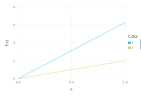

In [3]:
f(x) = π*x

plot([f, x -> x], 0, 1)

Of course, we almost never _know_ the function we want to learn. Instead, we usually have samples from the function, like so: 

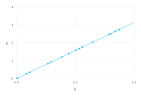

In [4]:
xys = [(x, f(x)) for x in rand(17)]

plot(
    layer(f, 0, 1),
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point)
)

- Now let us build the simplest model, with only **one** parameter: a weight `w`. 
- Next, let's initialize it with a random number. 
- And finally, define a function predict, which applies the model to our input. 

In [5]:
# A simple model to start with.
mutable struct LinearModel
    # Weight(s)
    w::Float64
end
# Initialisation doesn't have to be random, but it makes the step to neural models more natural.
LinearModel() = LinearModel(randn())
m             = LinearModel()
predict(m, x) = m.w*x


predict (generic function with 1 method)

Let's see what our randomly initialised model predicts!



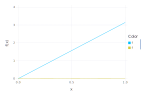

In [6]:
plot([f, x -> predict(m, x)], 0, 1)

This doesn't look good! But to make it better, we need to objectively define what "good" means. We usually do this via an **objective** function, or a loss function. 

In [7]:
# Mean Square Objective, note the "magic" divide by two.
objective(m, x, y) = (y - predict(m, x))^2/2
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)

# So, how "good" is our current random model?
objective(m, xys)

1.5083362416934336

To improve our model, we can change our weights $w$ by taking the gradient of the objective function with respect to $w$. 

Let's first re-write the loss to make things easier, we use $y\prime$ as a shorthand for a prediction.

1. `objective(m, x, y) = (y - predict(m, x))^2/2`
    - $(y - y\prime)^2/2$
    - $(y - wx)^2/2$
    - $(y - wx)(y - wx)/2$
    - $(y^2 - 2ywx + (wx)^2)/2$

Now, let's calculate the gradient with respect to $w$.

2. $(-2yx + 2wx^2)/2$
 - $(-yx + wx^2)$
 - $wx^2 - yx$
 - $x(wx - y)$

Now that we have hand-written our gradient function, let's put it in code. 

In [9]:
# Our gradient, but now in code.
∇objective(m, x, y) = x*(m.w*x - y)
∇objective(m, xys)  = mean(∇objective(m, x, y) for (x, y) in xys)
    
∇objective(m, xys)

-0.964387899008193

Just as a sanity check: let us verify our gradients via a finitedifference approach. 

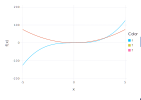

In [10]:

# https://en.wikipedia.org/wiki/Finite_difference
finitediff(f, x; ϵ=10.0^-8.0) = (f(x + ϵ) - f(x - ϵ))/(2ϵ)

g(x)  = x^3
g′(x) = 3x^2

plot([g, g′, x -> finitediff(g, x)], -5, 5)

Now let's plot the gradients with our original model, calculated two ways: our handwritten way, and the finite difference. 

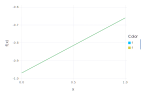

In [11]:
plot([w -> ∇objective(LinearModel(w), xys), w -> finitediff(v -> objective(LinearModel(v), xys), w)], 0, 1)

And let us verify this numerically too. 

In [12]:
mean((g′(x) - finitediff(g, x))^2 for x in linspace(-5, 5, 1024))

8.763533108456374e-14

In [13]:
mean((∇objective(LinearModel(w), xys) - finitediff(v -> objective(LinearModel(v), xys), w))^2 for w in linspace(-5, 5, 1024))

1.3121567182203172e-15

Now that we've verified our gradients, we can easily write a learning loop to estimate the appropriate parameter for our model!

In [14]:
# Learning rate (or step size).
μ = 0.1

# Save models for plotting.
models = LinearModel[deepcopy(m)]

# Gradient descent.
for _ in 1:128
    m.w -= μ*∇objective(m, xys)
    push!(models, deepcopy(m))
end

objective(m, xys)

0.0004975923920669699

Now let us plot the value of the objective function with every iteration. 

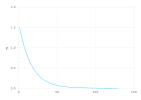

In [15]:
plot(y=[objective(m, xys) for m in models], Geom.line)

Now onto something more fun: since we've saved all our models, we can see how our predicted model keeps getting closer and closer to our original function `f(x)` with every iteration, until it finally converges.

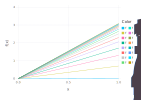

In [16]:
plot([x -> predict(models[j], x) for j in (convert(Int, floor(i)) for i in linspace(1, length(models), 16))], 0, 1)

## A slightly less simple linear function

Let's now move onto a slightly less simple linear function with two parameters instead of one. 

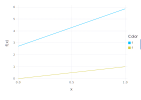

In [17]:
f(x) = π*x + e

plot([f, x -> x], 0, 1)

And as before, let us generate our samples and plot them.

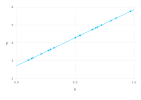

In [18]:
xys = [(x, f(x)) for x in rand(17)]

plot(
    layer(f, 0, 1),
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point)
)

First let's try the model we built the previous time. Does it actually work though?

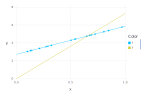

In [19]:
m                  = LinearModel()
objective(m, x, y) = (f(x) - predict(m, x))^2/2

for _ in 1:128
    m.w -= μ*∇objective(m, xys)
end
plot(
    layer([f, x -> predict(m, x)], 0, 1),
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point)
)

Since that didn't work, perhaps it's time to try a more complex model. 

In [20]:
mutable struct LinearModelWithBias
    w::Float64
    b::Float64
end
LinearModelWithBias() = LinearModelWithBias(randn(), 0)
m                     = LinearModelWithBias()

# Prediction function
predict(m, x)         = m.w*x + m.b

# Objective function 
objective(m, x, y) = (f(x) - predict(m, x))^2/2
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)

# Gradients 
∇objective(m, x, y) = [x*((m.w*x + m.b) - y), (m.w*x + m.b) - y]
∇objective(m, xys)  = mean(∇objective(m, x, y) for (x, y) in xys)

models = LinearModelWithBias[deepcopy(m)]        

# Learning loop
for _ in 1:512
    ∇w, ∇b = ∇objective(m, xys)
    m.w -= μ*∇w
    m.b -= μ*∇b
    push!(models, deepcopy(m))
end

objective(m, xys)

0.00021075167406979834

Having gone through all the steps as before, let's now plot the objective function with every iteration.

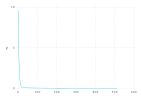

In [21]:
plot(y=[objective(m, xys) for m in models], Geom.line)

And like last time, observe the behaviour of our model.

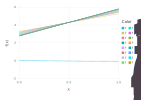

In [22]:
plot([x -> predict(models[j], x) for j in (convert(Int, floor(i)) for i in linspace(1, length(models), 16))], 0, 1)

Real world examples are always noisy though, so instead of working with perfect samples, let's work on one with noise. 

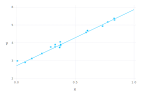

In [23]:
xys = [(x, f(x) + randn()/7) for x in rand(17)]

plot(
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point),
    layer(f, 1, 0)
)

As usual, go through our various steps again.

In [24]:
m             = LinearModelWithBias()
predict(m, x) = m.w*x + m.b

objective(m, x, y) = (f(x) - predict(m, x))^2/2
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)

∇objective(m, x, y) = [x*((m.w*x + m.b) - y), (m.w*x + m.b) - y]
∇objective(m, xys)  = mean(∇objective(m, x, y) for (x, y) in xys)

models = LinearModelWithBias[deepcopy(m)]

for _ in 1:512
    ∇w, ∇b = ∇objective(m, xys)
    m.w -= μ*∇w
    m.b -= μ*∇b
    push!(models, deepcopy(m))
end

objective(m, xys)

0.002272551377826714

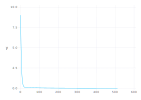

In [25]:
plot(y=[objective(m, xys) for m in models], Geom.line)

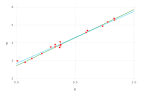

In [26]:
plot(
    layer(x=[x for (x, _) in xys], y=[y for (_, y) in xys], Geom.point, Theme(default_color = "red")),
    layer(x -> predict(m, x), 0, 1),
    layer(f, 0, 1, Theme(default_color = "green"))
)

## Classifiers - Apples and Oranges

Let us now play with a simple toy dataset and build a simple classifier. This dataset contains apples, oranges and lemons. In Julia, we can use set notation to specify the labels that refer to different fruits. 

In [42]:
apples  = Set([1, 3, 4, 5])
oranges = Set([2, 6, 7, 8])
lemons  = Set([9, 10])

Set([9, 10])

Next, download the data from a public URL

In [43]:
# Download dataset 
isfile("fruit_data.tsv") || 
    download("http://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/fruit_data", "fruit_data.tsv")

true

We can use this set notation to now eliminate the labels we don't want, using standard set notation. (∈ , ∪)

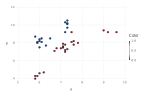

In [44]:
# Format: Label, Height, Width, Mass.
fruit_data = readdlm("fruit_data.tsv")

# Remove apples and make labels binary.
fruit_data                                 = fruit_data[fruit_data[:, 1] .∈ oranges ∪ lemons, :]
fruit_data[fruit_data[:, 1] .∈ oranges, 1] = 1
fruit_data[fruit_data[:, 1] .∈ lemons, 1]  = 0
# Only work with width and mass to make visualisation easier.
fruit_data = fruit_data[:, [1, 3, 4]]

plot(x=fruit_data[:, 2], y=fruit_data[:, 3], color=fruit_data[:, 1])

Let's use a random subset for training.

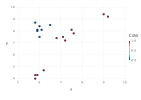

In [31]:
# Use a random subset for training, then evaluate generalisation on the rest.
intrain = rand(Bool, size(fruit_data, 1))

train = let
    w = fruit_data[intrain, :]
    [(w[i, 2:end], w[i, 1]) for i in 1:size(w, 1)]
end

plot(x=[x[1] for (x, y) in train], y=[x[2] for (x, _) in train], color=[y for (_, y) in train])

And the rest for testing.

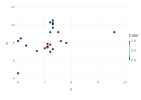

In [45]:
test = let
    w = fruit_data[.!intrain, :]
    [(w[i, 2:end], w[i, 1]) for i in 1:size(w, 1)]
end

plot(x=[x[1] for (x, _) in test], y=[x[2] for (x, _) in test], color=[y for (_, y) in test])

We're going to use a simple logistic function as our classifier for this problem. Let us define the logistic function and its derivative

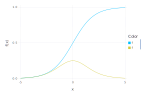

In [46]:
# https://en.wikipedia.org/wiki/Logistic_function
σ(x)  = 1/(1 + exp(-x))
σ′(x) = σ(x)*(1 - σ(x))

plot([σ, σ′], -5, 5)

And as earlier, define a classification model. 

In [47]:
# Our first classification model.
mutable struct ClassificationModel
    w::Array{Float64}
    b::Float64
end
# Be careful with the initialisation, too large weights hampers learning and may even break it.
ClassificationModel() = ClassificationModel(randn(2)/128, 0)
m                     = ClassificationModel()
predict(m, x)         = σ(m.w'*x + m.b)

println("y", '\t', "y′", '\t', "is orange?")
for (x, y) in train
    println(y, '\t', round(predict(m, x), 3), '\t', predict(m, x) > 0.5)
end

y	y′	is orange?
1.0	0.479	false
1.0	0.48	false
1.0	0.48	false
1.0	0.481	false
1.0	0.466	false
1.0	0.465	false
1.0	0.471	false
1.0	0.471	false
1.0	0.474	false
1.0	0.473	false
1.0	0.473	false
0.0	0.474	false
0.0	0.475	false
0.0	0.475	false
0.0	0.474	false
0.0	0.475	false
0.0	0.473	false
0.0	0.474	false


The objective function this time is a negative log likelihood. Minimizing this _maximizes_ the probability of our training data.

In [35]:
objective(m, x, y) = -(y*log(predict(m, x)) + (1 - y)*log(1 - predict(m, x)))
objective(m, xys)  = mean(objective(m, x, y) for (x, y) in xys)


(0.6939040961414508, 0.6936611871519808, 0.3888888888888889, 0.4090909090909091)

However, for our predictions, we want to work with a more human notation of "precision", which is defined as follows:

In [51]:
prec(m, xys)       = mean((predict(m, x) > 0.5) == (y == 1) for (x, y) in xys)

(objective(m, train), objective(m, test), prec(m, train), prec(m, test))

(0.706739390547777, 0.7039098482126169, 0.3888888888888889, 0.4090909090909091)

Now we need the derivative of the objective function (log likelihood)

In [52]:
# Warning, this gradient is significantly more difficult to derive -- but it turns out to be beautiful.
∇objective(m, x, y) = [x.*(σ(m.w'*x + m.b) - y), σ(m.w'*x + m.b) - y]

∇objective (generic function with 2 methods)

In [54]:
# We can no longer use `mean`, but this is functionally equivalent.
function ∇objective(m, xys)
    ∇ws = zero(m.w)
    ∇bs = zero(m.b)
    for (x, y) in xys
        ∇w, ∇b = ∇objective(m, x, y)
        ∇ws += ∇w
        ∇bs += ∇b
    end
    (∇ws/length(xys), ∇bs/length(xys))
end
 
∇objective(m, train)

([-1.17442, -0.656112], -0.1370566450779577)

In [55]:
models = ClassificationModel[deepcopy(m)]        

for _ in 1:2048
    ∇w, ∇b  = ∇objective(m, train)
    m.w    -= μ*∇w
    m.b    -= μ*∇b
    push!(models, deepcopy(m))
end

(objective(m, train), objective(m, test), prec(m, train), prec(m, test))

(0.021092138507234667, 0.11476833578509876, 1.0, 0.9545454545454546)

And, as before, plot the error with respect to number of iterations.

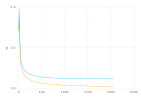

In [57]:
plot(
layer(y=[objective(m, train) for m in models], Geom.line, Theme(default_color = "orange")),
    layer(y=[objective(m, test) for m in models], Geom.line),
)

And now, look at our results!

In [58]:
println("y", '\t', "y′", '\t', "is orange?")
for (x, y) in train
    println(y, '\t', round(predict(m, x), 3), '\t', predict(m, x) > 0.5)
end

y	y′	is orange?
1.0	1.0	true
1.0	1.0	true
1.0	1.0	true
1.0	1.0	true
1.0	0.993	true
1.0	0.999	true
1.0	0.952	true
1.0	0.991	true
1.0	0.921	true
1.0	0.971	true
1.0	0.995	true
0.0	0.0	false
0.0	0.125	false
0.0	0.01	false
0.0	0.003	false
0.0	0.007	false
0.0	0.025	false
0.0	0.018	false


In [59]:
println("y", '\t', "y′", '\t', "is orange?")
for (x, y) in test
    println(y, '\t', round(predict(m, x), 3), '\t', predict(m, x) > 0.5)
end

y	y′	is orange?
1.0	1.0	true
1.0	1.0	true
1.0	0.164	false
1.0	0.961	true
1.0	0.969	true
1.0	0.971	true
1.0	0.993	true
1.0	0.998	true
1.0	0.864	true
1.0	0.957	true
1.0	0.995	true
1.0	0.941	true
1.0	0.956	true
0.0	0.0	false
0.0	0.0	false
0.0	0.042	false
0.0	0.001	false
0.0	0.009	false
0.0	0.002	false
0.0	0.007	false
0.0	0.003	false
0.0	0.215	false


In practice, overfitting is usually countered by adding $\lambda |w|$ to the loss function, where $\lambda$ is the regularisation strength.  This hyperparameter is then tuned on a third validation dataset.